In [1]:
#%xmode Verbose

In [2]:
import sys
sys.path.append("../libs/")

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import EarlyStopping
from utils import shift_join_data, rmse,mae,mape, print_line, plot_pred
from keras.models import load_model
from keras.utils.vis_utils import plot_model
import datetime

In [4]:
# Ruta del modelo con hiperparametros optimizados (sin entrenar)
model_path = '../modelamiento/ajustes/MLP_20220723_1234.h5'
# Callback para detener el entrenamiento cuando el error de validacion no disminuye despues de 50 epocas
es = EarlyStopping(monitor='val_loss', mode='min', patience=50,restore_best_weights=True)
mini_batch = 32
n_epochs= 2000  # Nro de epocas maximas
fecha_hora = datetime.datetime.now().strftime('%Y%m%d_%H%M')
res_name = 'resultados/MLP_'+fecha_hora
n_iter = 100

In [5]:
#notification
from getpass import getpass 
email = 'valegrei@outlook.com'
passwd = getpass('passwd:')
to_addr = 'victoralegre@uni.pe'

# Carga de datos

In [6]:
df = pd.read_csv('../data/wb_dataset_prep.csv')
df = df.drop('country',axis=1)
iso = df['iso'].unique()    #Codigos de paises
df = df.set_index(['iso','year'])

Paises

In [7]:
print(iso)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'PER'
 'POL' 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2444 entries, ('DEU', 1983) to ('NZL', 2021)
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   trade        2444 non-null   float64
 1   exports      2444 non-null   float64
 2   imports      2444 non-null   float64
 3   ggfce        2444 non-null   float64
 4   gfcf         2444 non-null   float64
 5   unempl       2444 non-null   float64
 6   rgdp_growth  2444 non-null   float64
 7   infl_cpi     2444 non-null   float64
 8   oil          2444 non-null   float64
 9   gold         2444 non-null   float64
 10  copper       2444 non-null   float64
 11  sp500        2444 non-null   float64
dtypes: float64(12)
memory usage: 239.0+ KB


# Dividir Datos

In [9]:
iso_test = ['PER']
iso_train = iso[(iso != iso_test[0])]
target_col = ['rgdp_growth']
features = df.columns[(df.columns!=target_col[0])]
df_test = df.copy()


Países de Entrenamiento

In [10]:
print(iso_train)

['DEU' 'AUS' 'AUT' 'BGD' 'BEL' 'BOL' 'BRA' 'CAN' 'CHL' 'CHN' 'COL' 'CRI'
 'HRV' 'DNK' 'ECU' 'SLV' 'ESP' 'USA' 'EST' 'RUS' 'FIN' 'FRA' 'GRC' 'GTM'
 'HND' 'HUN' 'IND' 'IDN' 'IRL' 'ISL' 'ISR' 'ITA' 'JPN' 'JOR' 'KEN' 'LTU'
 'LUX' 'MYS' 'MLT' 'MAR' 'MEX' 'NGA' 'NOR' 'NLD' 'PAK' 'PAN' 'PRY' 'POL'
 'PRT' 'GBR' 'EGY' 'KOR' 'ROU' 'SWE' 'CHE' 'TUR' 'URY' 'NZL']


Features de Entrenamiento

In [11]:
print(features)

Index(['trade', 'exports', 'imports', 'ggfce', 'gfcf', 'unempl', 'infl_cpi',
       'oil', 'gold', 'copper', 'sp500'],
      dtype='object')


# Normalizar

In [12]:
df_x_train = df.loc[iso_train][features].copy()
df_y_train = df.loc[iso_train][target_col].copy()
df_x_test = df_test.loc[iso_test][features].copy()
df_y_test = df_test.loc[iso_test][target_col].copy()

std_scaler_x_train = StandardScaler()
std_scaler_y_train = StandardScaler()
std_scaler_x_test = StandardScaler()
std_scaler_y_test = StandardScaler()

df_x_train.iloc[:,:] = std_scaler_x_train.fit_transform(df_x_train)
df_y_train.iloc[:,:] = std_scaler_y_train.fit_transform(df_y_train)
df_x_test.iloc[:,:] = std_scaler_x_test.fit_transform(df_x_test)
df_y_test.iloc[:,:] = std_scaler_y_test.fit_transform(df_y_test)

df_x_train.iloc[:,:] = np.clip(df_x_train,-3,3)
df_y_train.iloc[:,:] = np.clip(df_y_train,-3,3)
df_x_test.iloc[:,:] = np.clip(df_x_test,-3,3)
df_y_test.iloc[:,:] = np.clip(df_y_test,-3,3)

# Generar variables lag y horizonte

In [13]:
n_steps_in = 10
n_steps_out = 3
n_features = len(features)

x_train, y_train = shift_join_data(df_x_train,df_y_train,iso_train,n_steps_in,n_steps_out)
x_test, y_test = shift_join_data(df_x_test,df_y_test,iso_test,n_steps_in,n_steps_out)
x_test, y_test = x_test[- int(len(x_test)*0.2):], y_test[- int(len(y_test)*0.2):]


# Entrenamiento y evaluación

In [14]:
def evaluar_mlp(x_train : np.ndarray, y_train : np.ndarray, x_test : np.ndarray,
        y_test : np.ndarray, n_iter : int, scaler : StandardScaler):
    n_splits = 5    # Nro de K Folds para CV
    res_path = res_name+'.csv'
    tscv = TimeSeriesSplit(n_splits = n_splits)
    print_line("rmse,mae,mape\n",res_path)
    # Inicio
    gl_rmse = list()
    nro = 0
    print('Inicio de evaluacion:')
    for i in range(n_iter):
        val_rmse = list()
        val_mae = list()
        val_mape = list()
        for train_idx, test_idx in tscv.split(x_train):
            # CV split
            x_t, y_t = x_train[train_idx], y_train[train_idx]
            x_v, y_v = x_train[test_idx], y_train[test_idx]
            # Entrenamiento
            model = load_model(model_path)
            model.fit(x_t, y_t, validation_data = (x_v, y_v), epochs = n_epochs,
                batch_size = mini_batch, callbacks = [es], shuffle = False, verbose = 0)
            # Prediccion
            y_pred = model(x_test)
            # Denormalizando
            dn_y_test = scaler.inverse_transform(y_test)
            dn_y_pred = scaler.inverse_transform(y_pred)
            # Evaluacion
            val_rmse.append(rmse(dn_y_test, dn_y_pred))
            val_mae.append(mae(dn_y_test, dn_y_pred))
            val_mape.append(mape(dn_y_test, dn_y_pred))

            gl_rmse.append(rmse(dn_y_test, dn_y_pred))

            model.save(f'{res_name}_{nro}.h5')
            nro += 1
        # Promedios
        mean_rmse = np.mean(val_rmse)
        mean_mae = np.mean(val_mae)
        mean_mape = np.mean(val_mape)
        print_line(f'{mean_rmse},{mean_mae},{mean_mape}\n',res_path)
        print(f'Iter: {(i+1)}/{n_iter} completado.')
    print('Fin de evaluacion.')
    mejor_modelo = np.argmin(gl_rmse)
    print('Mejor modelo: {}'.format(mejor_modelo))
    return mejor_modelo

In [15]:
# evaluar
nro_mejor = evaluar_mlp(x_train, y_train, x_test, y_test,n_iter,std_scaler_y_test)

Inicio de evaluacion:


2022-10-03 23:50:48.275060: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 23:50:49.114044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9915 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:17:00.0, compute capability: 8.6
2022-10-03 23:50:49.114551: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10088 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:65:00.0, compute capability: 8.6
2022-10-03 23:50:49.274661: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of t

Iter: 1/100 completado.
Iter: 2/100 completado.
Iter: 3/100 completado.
Iter: 4/100 completado.
Iter: 5/100 completado.
Iter: 6/100 completado.
Iter: 7/100 completado.
Iter: 8/100 completado.
Iter: 9/100 completado.
Iter: 10/100 completado.
Iter: 11/100 completado.
Iter: 12/100 completado.
Iter: 13/100 completado.
Iter: 14/100 completado.
Iter: 15/100 completado.
Iter: 16/100 completado.
Iter: 17/100 completado.
Iter: 18/100 completado.
Iter: 19/100 completado.
Iter: 20/100 completado.
Iter: 21/100 completado.
Iter: 22/100 completado.
Iter: 23/100 completado.
Iter: 24/100 completado.
Iter: 25/100 completado.
Iter: 26/100 completado.
Iter: 27/100 completado.
Iter: 28/100 completado.
Iter: 29/100 completado.
Iter: 30/100 completado.
Iter: 31/100 completado.
Iter: 32/100 completado.
Iter: 33/100 completado.
Iter: 34/100 completado.
Iter: 35/100 completado.
Iter: 36/100 completado.
Iter: 37/100 completado.
Iter: 38/100 completado.
Iter: 39/100 completado.
Iter: 40/100 completado.
Iter: 41/

# Resultados

In [16]:
df_res = pd.read_csv(res_name+'.csv')

In [17]:
df_res.describe()

,rmse,mae,mape
count,100.000000,100.000000,100.000000
mean,2.084188,1.591712,41.819562
std,0.197677,0.154687,4.224735
min,1.653996,1.237573,33.825144
25%,1.920673,1.479196,38.884019
50%,2.099582,1.584528,42.265574
75%,2.207297,1.696059,44.572091
max,2.754390,2.170093,57.195436


In [18]:
#df_res.plot.box()

# Prediccion con mejor modelo

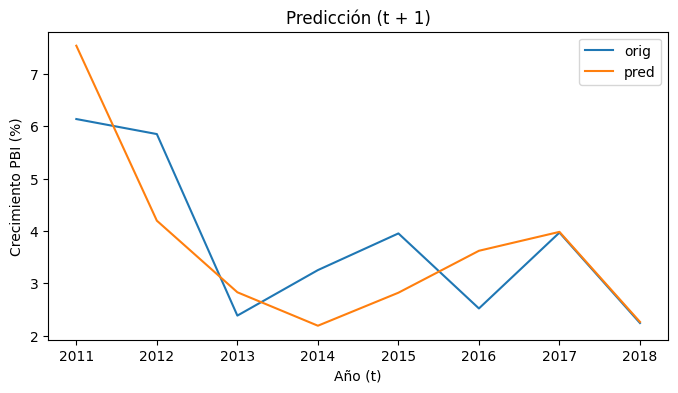

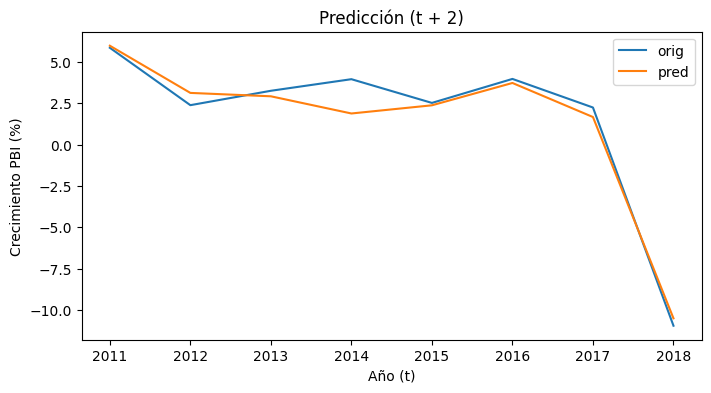

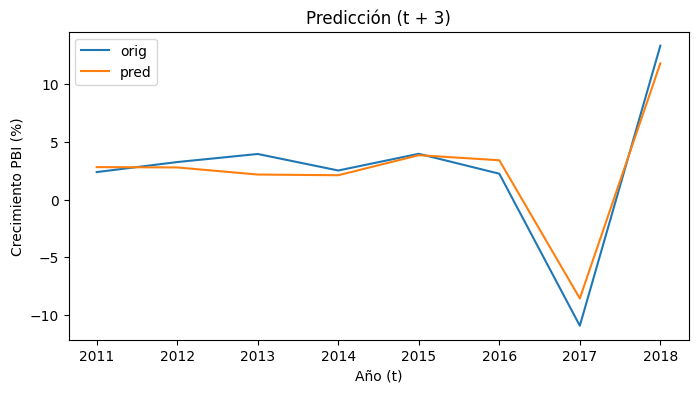

In [19]:

model = load_model(res_name+'_'+str(nro_mejor)+'.h5')
#model = load_model('resultados/MLP_20220801_0923_16.h5')
y_pred = model(x_test)
dn_y_test = std_scaler_y_test.inverse_transform(y_test)
dn_y_pred = std_scaler_y_test.inverse_transform(y_pred)
plot_pred(dn_y_test, dn_y_pred,2021)

In [20]:
#plot_model(model,'MLP.png',show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
from notifications import enviar_correo
enviar_correo(email,passwd,email,to_addr,"Evaluacion Finalizado!","Se ha completado: {}".format(res_name))